In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [15]:
color_dict = {  'Full precision': '#DC143C' , 
               'Post minmaxQ': '#3CB371', 
               'Post quantileQ': '#FF7F50', 
               'Pre minmaxQ': '#DAA520',
               'Pre quantileQ': '#6A5ACD', 
               'Bitwise minmaxQ': '#00BFFF', 
               'Bitwise quantileQ': '#FF8C00', 
               'SoftQ': '#F08080', 
               'Bitwise SoftQ': '#9370DB'}
plot_columns = list(color_dict.keys())

In [ ]:
def assign_marker_style(col):
    return 'o'
    if 'Pre' in col:
        return 'o'
    elif 'Post' in col:
        return '^'
    elif 'SoftQ' in col:
        return 'D'
    else: # Bitwise Hard
        return 'P'
    
def assign_linestyle(col):
    if 'minmaxQ' in col:
        return 'dashed'
    elif 'quantileQ' in col:
        return 'dashdot'
    elif 'SoftQ' in col:
        return 'solid'
    else: ## Full precision 
        return 'dotted'

linestyle_dict = {col: assign_linestyle(col) for col in plot_columns}
markerstyle_dict = {col: assign_marker_style(col) for col in plot_columns}

In [17]:
linestyle_dict

{'Full precision': 'dotted',
 'Post minmaxQ': 'dashed',
 'Post quantileQ': 'dashdot',
 'Pre minmaxQ': 'dashed',
 'Pre quantileQ': 'dashdot',
 'Bitwise minmaxQ': 'dashed',
 'Bitwise quantileQ': 'dashdot',
 'SoftQ': 'solid',
 'Bitwise SoftQ': 'solid'}

## Load data

## Utils

In [5]:
def rename_df_and_get_loss_cols(df):
        rename_dict = {'val_loss_mlp': 'Full precision', 'val_loss_hard_post_mlp':  'Post minmaxQ',
                            'val_loss_hard_thr_post_mlp': 'Post quantileQ', 'val_loss_hard_pre_mlp': 'Pre minmaxQ',
                            'val_loss_hard_thr_pre_mlp': 'Pre quantileQ', 
                            'val_loss_soft_hard_mlp':'SoftQ', 'val_loss_soft_hard_comp_mlp':'Bitwise SoftQ',
                            'val_loss_hard_bitwise_minmax_mlp': 'Bitwise minmaxQ',
                            'val_loss_hard_bitwise_quantile_mlp': 'Bitwise quantileQ' }
        df.rename(columns=rename_dict, inplace=True)
        return df

In [6]:
def load_result(dataset, n_bits, results_folder, steps=100):
    filename = f"{results_folder}/{dataset}_hyperparameter_tuning_{n_bits}bits_{steps}steps.csv"
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Results file {filename} does not exist.")
    df = pd.read_csv(filename, index_col=0)
    df = rename_df_and_get_loss_cols(df)
    return df

In [7]:
def get_best_hyperparameter_setting(df_cv):
    df_cv_grouped = df_cv.groupby('hyperparameter_setting_id').mean()
    best_setting_id = df_cv_grouped.idxmin(axis=0)
    return best_setting_id

def get_best_results_cv(df_cv, k_fold=10):
    best_setting_id = get_best_hyperparameter_setting(df_cv)

    best_results = pd.DataFrame(index = range(k_fold), columns=plot_columns)
    for col in plot_columns:
        best_results[col] = df_cv[df_cv['hyperparameter_setting_id'] == best_setting_id[col]][col].values
    return best_results

In [8]:
def plot_boxplot(best_results):
    plt.figure(figsize=(12, 6))
    # plt.boxplot(best_results[plot_columns], patch_artist=True)#, color = [color_dict[col] for col in plot_columns],)
    sns.boxplot(data=best_results[plot_columns], palette=color_dict,linewidth=1.5, fliersize=0, showfliers=False)
    # for f in range(len(plot_columns)):
    #     plt.gca().patches[f].set_facecolor(color_dict[plot_columns[f]])
    #     plt.gca().patches[f].set_edgecolor('black')
    #     plt.gca().patches[f].set_linewidth(1.5)
    plt.axhline(y=best_results['Full precision'].mean(), color=color_dict['Full precision'], linestyle=linestyle_dict['Full precision'], label='Full Precision Mean Validation Loss')
    plt.legend()
    plt.title("Boxplot of Best Validation Loss Results")
    plt.ylabel("Validation Loss")
    plt.xlabel("Hyperparameter Settings")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [9]:
def get_results_multiple_bits(dataset, n_bits_list, results_folder, steps=100, k_fold = 10):
    mean_results = pd.DataFrame(index = n_bits_list, columns=plot_columns)
    for n_bits in n_bits_list:
        df_cv = load_result(dataset, n_bits, results_folder, steps)
        best_results = get_best_results_cv(df_cv, k_fold)
        mean_results.loc[n_bits,:] = best_results[plot_columns].mean().values.reshape(1, -1)
    return mean_results

In [10]:
def plot_mean_results(mean_results):
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    mean_results = mean_results.astype(float)
    mean_full_precision = mean_results['Full precision'].mean()
    legend_in = []
    legend_out = []
    for col in plot_columns:
        linestyle = linestyle_dict[col] if col in linestyle_dict else 'solid'
        color = color_dict[col] if col in color_dict else 'blue'
        marker = markerstyle_dict[col] if col in markerstyle_dict else 'o'
        if col != 'Full precision':
            # sns.lineplot(x=mean_results.index, y=mean_results[col], label=col, marker = 'o', linestyle=linestyle, color=color)
            lin, = ax.plot(mean_results.index, mean_results[col],  linestyle=linestyle, color=color, linewidth=1.5, alpha=0.5)
            mark, = ax.plot(mean_results.index, mean_results[col],  marker=marker, color=color, markersize = 8, alpha=1, linestyle='')

            legend_in.append((lin, mark))
            legend_out.append(col)

        else:
            ax.axhline(y=mean_full_precision, color=color, linestyle=linestyle, label='Mean Full Precision')
    # sns.lineplot(data=mean_results)
    # plt.title("Mean Validation Loss for Different Bit Configurations")
    plt.ylabel("Mean Validation Loss")
    plt.xlabel("Number of Bits")
    plt.xticks(mean_results.index)
    ax.legend(legend_in, legend_out, title='Quantization Method')
    plt.tight_layout()
    plt.ylim(0.5,0.8)
    plt.show()

## Plotting CV results for single n_bits

In [11]:
dataset = 'wine_quality'
results_folder = "../results/CV/" 
n_bits = 5
steps = 1
k_fold = 10
df_cv = load_result(dataset = dataset, n_bits = n_bits, results_folder = results_folder, steps = steps)
best_results = get_best_results_cv(df_cv, k_fold=k_fold)

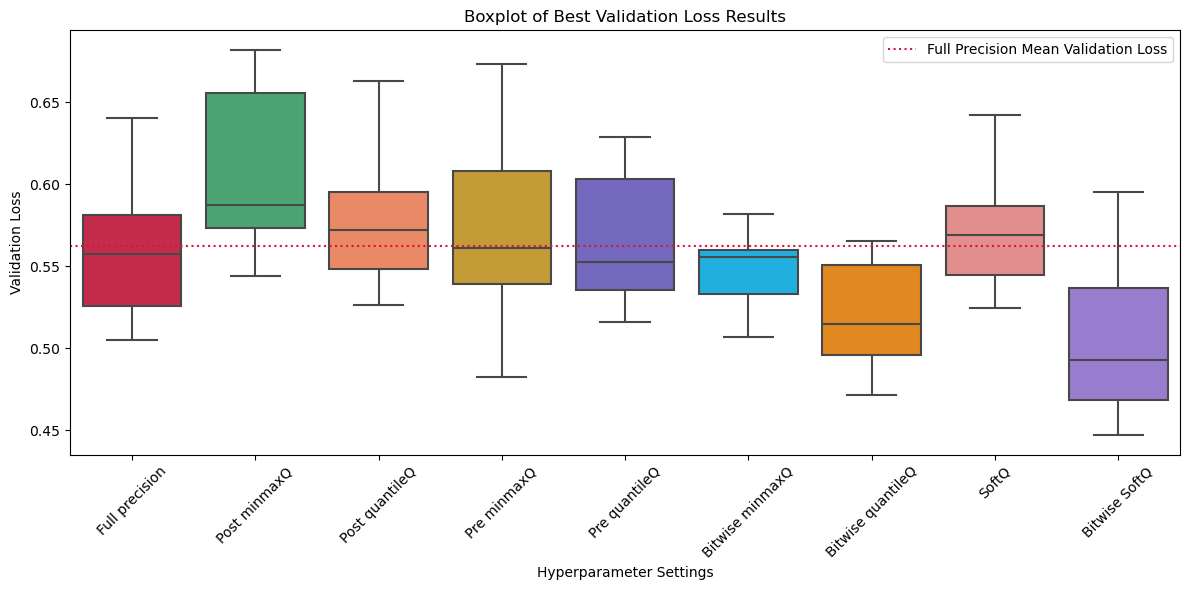

In [18]:
plot_boxplot(best_results)

## Plot for multiple n_bits

In [13]:
mean_results = get_results_multiple_bits(dataset = dataset, 
                                         n_bits_list = list(range(2,9)), 
                                         results_folder = results_folder, 
                                         steps = steps,
                                         k_fold = k_fold)

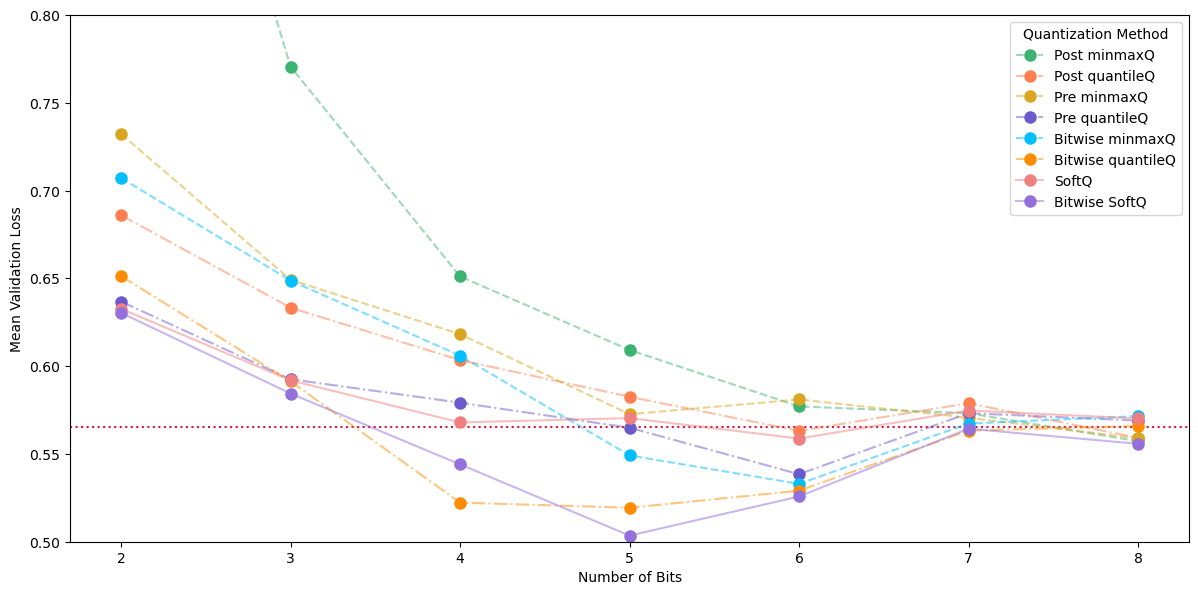

In [19]:
plot_mean_results(mean_results)